# Notes

In this notebook we find optimal architecture for RNN network and compare its performance with shallow and deep CNN.

# Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tf
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

# import os functions
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Load the data

### Read the files

In [4]:
X_test = np.load("./EEG_data/X_test.npy")
y_test = np.load("./EEG_data/y_test.npy") - 769
person_train_valid = np.load("./EEG_data/person_train_valid.npy")
X_train_valid = np.load("./EEG_data/X_train_valid.npy")
y_train_valid = np.load("./EEG_data/y_train_valid.npy") - 769
person_test = np.load("./EEG_data/person_test.npy")

print("training/Valid data shape: {}".format(X_train_valid.shape))       # training data of many persons
print("Test data shape: {}".format(X_test.shape))                        # test data of many persons
print("Training/Valid target shape: {}".format(y_train_valid.shape))     # training labels of many persons
print("Test target shape: {}".format(y_test.shape))                      # test labels of many persons
print("Person train/valid  shape: {}".format(person_train_valid.shape))  # which person correspond to the trail in test set
print("Person test shape: {}".format(person_test.shape))                 # which person correspond to the trail in test set

training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid  shape: (2115, 1)
Person test shape: (443, 1)


### divide dataset into training and validation

In [5]:
perm = np.random.permutation(X_train_valid.shape[0])
num_train = int(0.8 * X_train_valid.shape[0])
num_valid = X_train_valid.shape[0] - num_train
X_train =  X_train_valid[perm[0:num_train]]
y_train =  y_train_valid[perm[0:num_train]]
X_valid = X_train_valid[perm[num_train: ]]
y_valid = y_train_valid[perm[num_train: ]]


print("Training data shape: {}".format(X_train.shape))
print("Training label shape: {}".format(y_train.shape))
print("Validation data shape: {}".format(X_valid.shape))
print("Validation label shape: {}".format(y_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Test label shape: {}".format(y_test.shape))

Training data shape: (1692, 22, 1000)
Training label shape: (1692,)
Validation data shape: (423, 22, 1000)
Validation label shape: (423,)
Test data shape: (443, 22, 1000)
Test label shape: (443,)


### Augmented dataset

In [50]:
def sliding_window(X_arr, y_arr, time_window=100, time_step=1, time_stride=1):
    temp_x = np.moveaxis(X_arr, 2, 0)
    temp_x = temp_x.astype(np.float32)
    buff = []
    
    num_slices = (len(temp_x)-time_window*time_step) // time_stride + 1
#     print('temp_x', len(temp_x))
#     print('time_window', time_window)
#     print('num_slices', num_slices)
    
    # get time slices for data
    for i in range(num_slices):
        buff.append(temp_x[i*time_stride:i*time_stride + time_window*time_step:time_step])
        buff[i] = np.moveaxis(buff[i], 0, 2)
        # uncomment this if additional dimension is needed
        # buff[i] = buff[i].reshape(1, buff[i].shape[0], buff[i].shape[1], buff[i].shape[2])
        
    temp_x = np.concatenate(buff)
        
    # get time slice for labels
    temp_y = np.ones((X_arr.shape[0],num_slices))
    
    for i in range(len(y_arr)):
        temp_y[i] = temp_y[i] * y_arr[i]
        
    temp_y = temp_y.reshape((-1))
    
    return temp_x, temp_y

# Experiment 1: Naive RNN model

In this experiment we calculate baseline accuracy for RNN model.

### Construct model

In [7]:
keras.backend.clear_session()

# input
naive_rnn_input = layers.Input(shape=(22, 1000))
# conv across channels?
p1 = layers.Permute((2, 1))(naive_rnn_input)
lstm1 = layers.LSTM(64, return_sequences=True)(p1)
lstm2 = layers.LSTM(64, return_sequences=True)(lstm1)
f2 = layers.Flatten()(lstm2)
d2 = layers.Dense(64, activation="elu")(f2)

# output
naive_rnn_output = layers.Dense(4, activation="softmax")(d2)

### Compile model

In [8]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/naive_rnn_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


naive_rnn_model = keras.Model(inputs = naive_rnn_input, outputs = naive_rnn_output, name="naive_rnn_model")
naive_rnn_model.compile(optimizer="Adam", 
                        loss="sparse_categorical_crossentropy", 
                        metrics=["acc"])

In [9]:
naive_rnn_model.summary()

Model: "naive_rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
permute (Permute)            (None, 1000, 22)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 64)          22272     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4096064   
_________________________________________________________________
dense_1 (Dense)              (None, 4)             

### Train model

In [10]:
naive_rnn_model_loss_hist = naive_rnn_model.fit(X_train, y_train,
                                                validation_data = (X_valid, y_valid),
                                                epochs = 5,
                                                callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.5937 - acc: 0.3612
Epoch 00001: val_loss improved from inf to 1.31295, saving model to ./model_checkpoints/naive_rnn_1000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model_checkpoints/naive_rnn_1000/assets
1692/1692 [==============================] - 9s 5ms/sample - loss: 1.5883 - acc: 0.3617 - val_loss: 1.3129 - val_acc: 0.3593
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.8450 - acc: 0.6630
Epoch 00002: val_loss did not improve from 1.31295
1692/1692 [==============================] - 3s 2ms/sample - loss: 0.8463 - acc: 0.6625 - val_loss: 1.3216 - val_acc: 0.4657
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.4434 - acc: 0.8474
Epoch 00003: val_loss did not improve from 1.31295
1692/1692 [==============================] - 3s 2ms/sample - los

### Produce graphs

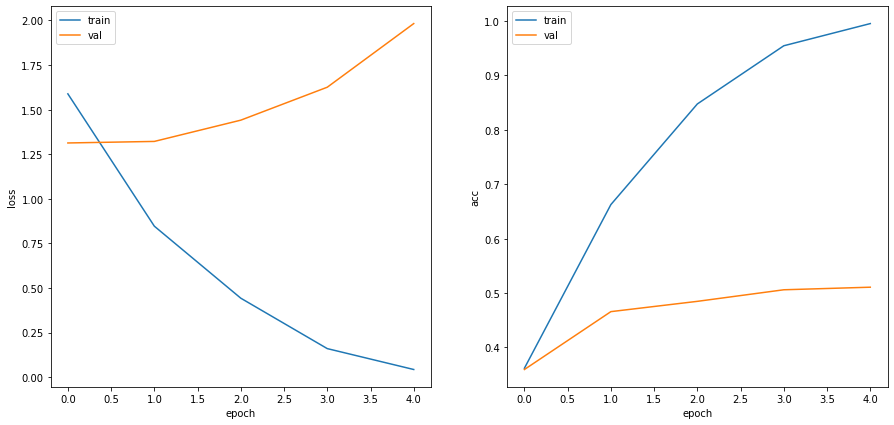

In [11]:
hist = naive_rnn_model_loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Experiment 2: RNN with more layers.

In this experiment, we compare performance of baseline RNN and RNNs with more layers.

In [12]:
# input
rnn_3_lstm_1_dense_input = layers.Input(shape=(22, 1000))

# conv across channels?
p1 = layers.Permute((2, 1))(rnn_3_lstm_1_dense_input)
lstm1 = layers.LSTM(64, return_sequences=True)(p1)
lstm2 = layers.LSTM(64, return_sequences=True)(lstm1)
lstm3 = layers.LSTM(64, return_sequences=True)(lstm2)
f2 = layers.Flatten()(lstm3)
d2 = layers.Dense(64, activation="elu")(f2)

# output
rnn_3_lstm_1_dense_output = layers.Dense(4, activation="softmax")(d2)

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_3_lstm_1_dense_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


rnn_3_lstm_1_dense_model = keras.Model(inputs = rnn_3_lstm_1_dense_input, outputs = rnn_3_lstm_1_dense_output)
rnn_3_lstm_1_dense_model.compile(optimizer="Adam", 
                                 loss="sparse_categorical_crossentropy", 
                                 metrics=["acc"])

rnn_3_lstm_1_dense_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
permute_1 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000, 64)          22272     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                409606

In [13]:
rnn_3_lstm_1_dense_model_loss_hist = rnn_3_lstm_1_dense_model.fit(X_train, y_train,
                                                                  validation_data = (X_valid, y_valid),
                                                                  epochs = 5,
                                                                  callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.5799 - acc: 0.3407
Epoch 00001: val_loss improved from inf to 1.27861, saving model to ./model_checkpoints/rnn_3_lstm_1_dense_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_3_lstm_1_dense_1000/assets
1692/1692 [==============================] - 12s 7ms/sample - loss: 1.5747 - acc: 0.3416 - val_loss: 1.2786 - val_acc: 0.3759
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.0436 - acc: 0.5577
Epoch 00002: val_loss improved from 1.27861 to 1.20817, saving model to ./model_checkpoints/rnn_3_lstm_1_dense_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_3_lstm_1_dense_1000/assets
1692/1692 [==============================] - 10s 6ms/sample - loss: 1.0386 - acc: 0.5585 - val_loss: 1.2082 - val_acc: 0.4799
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.8256 - acc: 0.6472
Epoch 00003: val_loss did

In [14]:
# input
rnn_3_lstm_2_dense_input = layers.Input(shape=(22, 1000))

# conv across channels?
p1 = layers.Permute((2, 1))(rnn_3_lstm_2_dense_input)
lstm1 = layers.LSTM(64, return_sequences=True)(p1)
lstm2 = layers.LSTM(64, return_sequences=True)(lstm1)
lstm3 = layers.LSTM(64, return_sequences=True)(lstm2)
f2 = layers.Flatten()(lstm3)
d2 = layers.Dense(64, activation="elu")(f2)
d3 = layers.Dense(64, activation="elu")(d2)


# output
rnn_3_lstm_2_dense_output = layers.Dense(4, activation="softmax")(d3)

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_3_lstm_2_dense_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


rnn_3_lstm_2_dense_model = keras.Model(inputs = rnn_3_lstm_2_dense_input, outputs = rnn_3_lstm_2_dense_output)
rnn_3_lstm_2_dense_model.compile(optimizer="Adam", 
                                 loss="sparse_categorical_crossentropy", 
                                 metrics=["acc"])

rnn_3_lstm_2_dense_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
permute_2 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000, 64)          22272     
_________________________________________________________________
lstm_6 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4096

In [15]:
rnn_3_lstm_2_dense_model_loss_hist = rnn_3_lstm_2_dense_model.fit(X_train, y_train,
                                                                  validation_data = (X_valid, y_valid),
                                                                  epochs = 5,
                                                                  callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.5535 - acc: 0.3389
Epoch 00001: val_loss improved from inf to 1.27027, saving model to ./model_checkpoints/rnn_3_lstm_2_dense_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_3_lstm_2_dense_1000/assets
1692/1692 [==============================] - 12s 7ms/sample - loss: 1.5477 - acc: 0.3398 - val_loss: 1.2703 - val_acc: 0.4113
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.9374 - acc: 0.6274
Epoch 00002: val_loss did not improve from 1.27027
1692/1692 [==============================] - 5s 3ms/sample - loss: 0.9358 - acc: 0.6283 - val_loss: 1.2917 - val_acc: 0.4563
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.5381 - acc: 0.8035
Epoch 00003: val_loss did not improve from 1.27027
1692/1692 [==============================] - 5s 3ms/sample - loss: 0.5386 - acc: 0.8038 - val_loss: 1.4260 - val_acc: 0.4775
E

# Experiment 2 conclusion:

It can be argued, but based on the validation loss dynamics we can say that RNN does not significantly benefit from more layers.

# Experiment 3: augmentation of RNN architecture.

In this experiment, we show how RNN architecture is affected by architecture modifications, such as regularization,  number of hidden units, dropout. We start with dropout ~ 0.3 which is a common solution. Then we try different regularization, adter which variate number of hidden units and then dropout rate.

In [16]:
def construct_rnn_lstm_model(TIME_WINDOW=1000, hidden_units=64, dropout=0, regularizer=0):
    # input
    aug_rnn_input = layers.Input(shape=(22, TIME_WINDOW))

    p1 = layers.Permute((2, 1))(aug_rnn_input)
    lstm1 = layers.LSTM(hidden_units, 
                        return_sequences=True, 
                        dropout=dropout, 
                        kernel_regularizer=keras.regularizers.l2(regularizer))(p1)
    lstm2 = layers.LSTM(hidden_units, 
                        return_sequences=True, 
                        dropout=dropout,
                        kernel_regularizer=keras.regularizers.l2(regularizer))(lstm1)


    f2 = layers.Flatten()(lstm2)
    do2 = layers.Dropout(dropout)(f2)
    elu2 = layers.Dense(hidden_units, activation="elu",  kernel_regularizer=keras.regularizers.l2(regularizer))(do2)

    # output
    aug_rnn_output = layers.Dense(4, activation="softmax")(elu2)
    
    return keras.Model(inputs = aug_rnn_input, outputs = aug_rnn_output)

In [17]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.0001

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_00001_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                  HIDDEN, 
                                                                                  DROPOUT, 
                                                                                  REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_00001_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_00001_reg_1000.fit(X_train, y_train,
                                                           validation_data = (X_valid, y_valid),
                                                           epochs = 5,
                                                           callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.6461 - acc: 0.3642
Epoch 00001: val_loss improved from inf to 1.26457, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000/assets
1692/1692 [==============================] - 9s 5ms/sample - loss: 1.6395 - acc: 0.3647 - val_loss: 1.2646 - val_acc: 0.4515
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.9908 - acc: 0.6310
Epoch 00002: val_loss improved from 1.26457 to 1.24086, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000/assets
1692/1692 [==============================] - 7s 4ms/sample - loss: 0.9927 - acc: 0.6300 - val_loss: 1.2409 - val_acc: 0.5177
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.7900 - acc: 0.

In [18]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.001

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_2_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_0001_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                 HIDDEN, 
                                                                                 DROPOUT, 
                                                                                 REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_0001_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_0001_reg_1000.fit(X_train, y_train,
                                                           validation_data = (X_valid, y_valid),
                                                           epochs = 5,
                                                           callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.1364 - acc: 0.3293
Epoch 00001: val_loss improved from inf to 1.64848, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_2_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_2_conig_1000/assets
1692/1692 [==============================] - 9s 5ms/sample - loss: 2.1284 - acc: 0.3327 - val_loss: 1.6485 - val_acc: 0.4090
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.4633 - acc: 0.5252
Epoch 00002: val_loss improved from 1.64848 to 1.57879, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_2_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_2_conig_1000/assets
1692/1692 [==============================] - 7s 4ms/sample - loss: 1.4628 - acc: 0.5254 - val_loss: 1.5788 - val_acc: 0.4397
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.2006 - acc: 0.

In [19]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.005

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_0005_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                 HIDDEN, 
                                                                                 DROPOUT, 
                                                                                 REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_0005_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_0005_reg_1000.fit(X_train, y_train,
                                                           validation_data = (X_valid, y_valid),
                                                           epochs = 5,
                                                           callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 3.4013 - acc: 0.3528
Epoch 00001: val_loss improved from inf to 2.81507, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000/assets
1692/1692 [==============================] - 9s 5ms/sample - loss: 3.3913 - acc: 0.3546 - val_loss: 2.8151 - val_acc: 0.4184
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.4086 - acc: 0.5709
Epoch 00002: val_loss improved from 2.81507 to 2.38578, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000/assets
1692/1692 [==============================] - 7s 4ms/sample - loss: 2.4081 - acc: 0.5697 - val_loss: 2.3858 - val_acc: 0.4917
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.9852 - acc: 0.

In [20]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.01

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_001_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                HIDDEN, 
                                                                                DROPOUT, 
                                                                                REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_001_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_001_reg_1000.fit(X_train, y_train,
                                                         validation_data = (X_valid, y_valid),
                                                         epochs = 5,
                                                         callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 4.3516 - acc: 0.3444
Epoch 00001: val_loss improved from inf to 3.50695, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000/assets
1692/1692 [==============================] - 9s 5ms/sample - loss: 4.3367 - acc: 0.3434 - val_loss: 3.5069 - val_acc: 0.3546
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.8534 - acc: 0.5739
Epoch 00002: val_loss improved from 3.50695 to 2.74977, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000/assets
1692/1692 [==============================] - 7s 4ms/sample - loss: 2.8477 - acc: 0.5757 - val_loss: 2.7498 - val_acc: 0.4752
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.3737 - acc: 0.

# NEW EXPERIMENTS HERE

We have to iterate through regularization through range approximately [0.1 - 0.0001], dropout - 0.2-0.5, hidden units - 32 to 128, sampl

In [63]:
from tensorboard.plugins.hparams import api as hp

In [64]:
HP_TIME_WINDOW = hp.HParam('TIME_WINDOW', hp.Discrete([500, 750, 1000])) 
HP_HIDDEN = hp.HParam('HIDDEN', hp.Discrete([32, 64, 128]))
HP_DROPOUT = hp.HParam('DROPOUT', hp.Discrete([0.2, 0.3, 0.4, 0.5]))
HP_REGULARIZER = hp.HParam('REGULARIZER', hp.Discrete([.00001, .0001, .0005,.001, .005,.01]))
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_TIME_WINDOW, HP_HIDDEN, HP_DROPOUT, HP_REGULARIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
)

In [65]:
def construct_rnn_lstm_model(hparams):
    # input
    aug_rnn_input = layers.Input(shape=(22, hparams[HP_TIME_WINDOW]))

    p1 = layers.Permute((2, 1))(aug_rnn_input)
    lstm1 = layers.LSTM(hparams[HP_HIDDEN], 
                        return_sequences=True, 
                        dropout=hparams[HP_DROPOUT], 
                        kernel_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]))(p1)
    lstm2 = layers.LSTM(hparams[HP_HIDDEN], 
                        return_sequences=True, 
                        dropout=hparams[HP_DROPOUT],
                        kernel_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]))(lstm1)


    f2 = layers.Flatten()(lstm2)
    do2 = layers.Dropout(hparams[HP_DROPOUT])(f2)
    elu2 = layers.Dense(hparams[HP_HIDDEN], activation="elu",  kernel_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]))(do2)

    # output
    aug_rnn_output = layers.Dense(4, activation="softmax")(elu2)
    
    return keras.Model(inputs = aug_rnn_input, outputs = aug_rnn_output)

In [66]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_lstm_model' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

def train_test_rnn_lstm_model(hparams):
    rnn_lstm_model = construct_rnn_lstm_model(hparams)

    rnn_lstm_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
    rnn_lstm_model.summary()
    rnn_lstm_model.fit(X_train_slices, y_train_slices, validation_data = (X_valid_slices, y_valid_slices), epochs = 5, callbacks=checkpoint_callback)
    _, accuracy = rnn_lstm_model.evaluate(X_test_slices, y_test_slices)
    return accuracy


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_rnn_lstm_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [67]:
session_num = 0
TIME_STRIDE = 1000
for window_size in HP_TIME_WINDOW.domain.values:
            
    X_train_slices, y_train_slices = sliding_window(X_train, 
                                                    y_train, 
                                                    time_window=window_size,  
                                                    time_stride=TIME_STRIDE)


    X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                    y_valid, 
                                                    time_window=window_size, 
                                                    time_stride=TIME_STRIDE)

    X_test_slices, y_test_slices = sliding_window(X_test, 
                                                    y_test, 
                                                    time_window=window_size, 
                                                    time_stride=TIME_STRIDE)

    print("Training data shape with slices: {}".format(X_train_slices.shape))
    print("Training label shape with slice: {}".format(y_train_slices.shape))
    print("Validation data shape with slices: {}".format(X_valid_slices.shape))
    print("Validation label shape with slice: {}".format(y_valid_slices.shape))
    print("Testing data shape with slices: {}".format(X_test_slices.shape))
    print("Testing label shape with slice: {}".format(y_test_slices.shape))
    for num_units in HP_HIDDEN.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for reg in HP_REGULARIZER.domain.values:
                hparams = {
                    HP_TIME_WINDOW: window_size,
                    HP_HIDDEN: num_units,
                    HP_DROPOUT: dropout_rate,
                    HP_REGULARIZER: reg,
                }

                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run('logs/hparam_tuning/' + run_name, hparams)
                session_num += 1


Training data shape with slices: (1692, 22, 500)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 500)
Validation label shape with slice: (423,)
Testing data shape with slices: (443, 22, 500)
Testing label shape with slice: (443,)
--- Starting trial: run-0
{'TIME_WINDOW': 500, 'HIDDEN': 32, 'DROPOUT': 0.2, 'REGULARIZER': 1e-05}
Model: "model_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 22, 500)]         0         
_________________________________________________________________
permute_106 (Permute)        (None, 500, 22)           0         
_________________________________________________________________
lstm_214 (LSTM)              (None, 500, 32)           7040      
_________________________________________________________________
lstm_215 (LSTM)              (None, 500, 32)           8320      
____________________

Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1228 - acc: 0.5803
Epoch 00002: val_loss did not improve from 1.17861
1692/1692 [==============================] - 2s 920us/sample - loss: 1.1301 - acc: 0.5786 - val_loss: 1.4578 - val_acc: 0.4681
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.9746 - acc: 0.6412
Epoch 00003: val_loss did not improve from 1.17861
1692/1692 [==============================] - 2s 918us/sample - loss: 0.9773 - acc: 0.6401 - val_loss: 1.4316 - val_acc: 0.4752
Epoch 4/5
1600/1692 [===========================>..] - ETA: 0s - loss: 0.8610 - acc: 0.6975
Epoch 00004: val_loss did not improve from 1.17861
1692/1692 [==============================] - 1s 875us/sample - loss: 0.8649 - acc: 0.6974 - val_loss: 1.4005 - val_acc: 0.5177
Epoch 5/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.7446 - acc: 0.7580
Epoch 00005: val_loss did not improve from 1.17861
443/443 [==============================] - 0s 4

1600/1692 [===========================>..] - ETA: 0s - loss: 2.8620 - acc: 0.3694
Epoch 00001: val_loss did not improve from 1.17861
1692/1692 [==============================] - 3s 2ms/sample - loss: 2.8430 - acc: 0.3753 - val_loss: 2.4788 - val_acc: 0.4326
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.1201 - acc: 0.5882
Epoch 00002: val_loss did not improve from 1.17861
1692/1692 [==============================] - 2s 946us/sample - loss: 2.1200 - acc: 0.5863 - val_loss: 2.2608 - val_acc: 0.4468
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.8136 - acc: 0.6358
Epoch 00003: val_loss did not improve from 1.17861
1692/1692 [==============================] - 2s 939us/sample - loss: 1.8127 - acc: 0.6365 - val_loss: 2.2564 - val_acc: 0.4657
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.6555 - acc: 0.6691
Epoch 00004: val_loss did not improve from 1.17861
1692/1692 [==============================] - 2s 930us/sampl

1600/1692 [===========================>..] - ETA: 0s - loss: 1.4784 - acc: 0.3837
Epoch 00001: val_loss did not improve from 1.15922
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.4719 - acc: 0.3859 - val_loss: 1.4188 - val_acc: 0.4232
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.1574 - acc: 0.5601
Epoch 00002: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 926us/sample - loss: 1.1559 - acc: 0.5615 - val_loss: 1.4582 - val_acc: 0.4255
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.0673 - acc: 0.5919
Epoch 00003: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 919us/sample - loss: 1.0661 - acc: 0.5922 - val_loss: 1.4486 - val_acc: 0.4232
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.9816 - acc: 0.6385
Epoch 00004: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 921us/sampl

1664/1692 [============================>.] - ETA: 0s - loss: 2.7870 - acc: 0.3756
Epoch 00001: val_loss did not improve from 1.15922
1692/1692 [==============================] - 3s 2ms/sample - loss: 2.7841 - acc: 0.3759 - val_loss: 2.5140 - val_acc: 0.4113
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.1765 - acc: 0.5270
Epoch 00002: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 929us/sample - loss: 2.1713 - acc: 0.5290 - val_loss: 2.1689 - val_acc: 0.4823
Epoch 3/5
1600/1692 [===========================>..] - ETA: 0s - loss: 1.8874 - acc: 0.5900
Epoch 00003: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 926us/sample - loss: 1.8860 - acc: 0.5887 - val_loss: 2.1254 - val_acc: 0.4752
Epoch 4/5
1600/1692 [===========================>..] - ETA: 0s - loss: 1.7220 - acc: 0.6212
Epoch 00004: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 913us/sampl

1632/1692 [===========================>..] - ETA: 0s - loss: 1.5043 - acc: 0.3695
Epoch 00001: val_loss did not improve from 1.15922
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.5012 - acc: 0.3694 - val_loss: 1.3415 - val_acc: 0.4704
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2085 - acc: 0.5202
Epoch 00002: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 927us/sample - loss: 1.2107 - acc: 0.5154 - val_loss: 1.3386 - val_acc: 0.4657
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1323 - acc: 0.5692
Epoch 00003: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 954us/sample - loss: 1.1299 - acc: 0.5715 - val_loss: 1.2580 - val_acc: 0.5248
Epoch 4/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.0619 - acc: 0.5919
Epoch 00004: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 948us/sampl

1600/1692 [===========================>..] - ETA: 0s - loss: 2.8396 - acc: 0.3344
Epoch 00001: val_loss did not improve from 1.15922
1692/1692 [==============================] - 4s 3ms/sample - loss: 2.8231 - acc: 0.3351 - val_loss: 2.5082 - val_acc: 0.4161
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.2564 - acc: 0.4952
Epoch 00002: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 906us/sample - loss: 2.2550 - acc: 0.4959 - val_loss: 2.1931 - val_acc: 0.4610
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.9522 - acc: 0.5138
Epoch 00003: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 935us/sample - loss: 1.9516 - acc: 0.5142 - val_loss: 2.0251 - val_acc: 0.5059
Epoch 4/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.8094 - acc: 0.5679
Epoch 00004: val_loss did not improve from 1.15922
1692/1692 [==============================] - 2s 968us/sampl

1664/1692 [============================>.] - ETA: 0s - loss: 1.5378 - acc: 0.3131
Epoch 00001: val_loss did not improve from 1.15729
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.5376 - acc: 0.3132 - val_loss: 1.3857 - val_acc: 0.3522
Epoch 2/5
1600/1692 [===========================>..] - ETA: 0s - loss: 1.3020 - acc: 0.4581
Epoch 00002: val_loss did not improve from 1.15729
1692/1692 [==============================] - 1s 871us/sample - loss: 1.2977 - acc: 0.4616 - val_loss: 1.3271 - val_acc: 0.4657
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2489 - acc: 0.4884
Epoch 00003: val_loss did not improve from 1.15729
1692/1692 [==============================] - 1s 875us/sample - loss: 1.2471 - acc: 0.4882 - val_loss: 1.2925 - val_acc: 0.4823
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1773 - acc: 0.5172
Epoch 00004: val_loss did not improve from 1.15729
1692/1692 [==============================] - 1s 882us/sampl

1664/1692 [============================>.] - ETA: 0s - loss: 2.8539 - acc: 0.3365
Epoch 00001: val_loss did not improve from 1.15729
1692/1692 [==============================] - 3s 2ms/sample - loss: 2.8509 - acc: 0.3381 - val_loss: 2.5630 - val_acc: 0.4563
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.3745 - acc: 0.4865
Epoch 00002: val_loss did not improve from 1.15729
1692/1692 [==============================] - 2s 900us/sample - loss: 2.3720 - acc: 0.4864 - val_loss: 2.2979 - val_acc: 0.4657
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.1361 - acc: 0.4822
Epoch 00003: val_loss did not improve from 1.15729
1692/1692 [==============================] - 2s 942us/sample - loss: 2.1302 - acc: 0.4846 - val_loss: 2.0817 - val_acc: 0.5177
Epoch 4/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.9393 - acc: 0.5391
Epoch 00004: val_loss did not improve from 1.15729
1692/1692 [==============================] - 2s 932us/sampl

1632/1692 [===========================>..] - ETA: 0s - loss: 1.6737 - acc: 0.3964
Epoch 00001: val_loss did not improve from 1.09647
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.6580 - acc: 0.4025 - val_loss: 1.3314 - val_acc: 0.4704
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1363 - acc: 0.5993
Epoch 00002: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.1343 - acc: 0.6011 - val_loss: 1.2507 - val_acc: 0.5390
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.8945 - acc: 0.7175
Epoch 00003: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 0.9014 - acc: 0.7134 - val_loss: 1.4875 - val_acc: 0.5059
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.7401 - acc: 0.7745
Epoch 00004: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 4.0008 - acc: 0.3977
Epoch 00001: val_loss did not improve from 1.09647
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.9743 - acc: 0.3995 - val_loss: 3.2043 - val_acc: 0.4208
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.5337 - acc: 0.6164
Epoch 00002: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.5337 - acc: 0.6117 - val_loss: 2.5439 - val_acc: 0.5201
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.0620 - acc: 0.6838
Epoch 00003: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.0717 - acc: 0.6779 - val_loss: 2.2902 - val_acc: 0.5248
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.8062 - acc: 0.7157
Epoch 00004: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.6905 - acc: 0.3958
Epoch 00001: val_loss did not improve from 1.09647
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.6816 - acc: 0.3954 - val_loss: 1.3191 - val_acc: 0.4965
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1866 - acc: 0.5821
Epoch 00002: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.1906 - acc: 0.5798 - val_loss: 1.2778 - val_acc: 0.5272
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.0274 - acc: 0.6562
Epoch 00003: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.0242 - acc: 0.6590 - val_loss: 1.3226 - val_acc: 0.5083
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.9091 - acc: 0.7126
Epoch 00004: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 4.0405 - acc: 0.3989
Epoch 00001: val_loss did not improve from 1.09647
1692/1692 [==============================] - 3s 2ms/sample - loss: 4.0123 - acc: 0.4043 - val_loss: 3.2449 - val_acc: 0.4728
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.6784 - acc: 0.5907
Epoch 00002: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.6676 - acc: 0.5904 - val_loss: 2.5662 - val_acc: 0.4917
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.2327 - acc: 0.6201
Epoch 00003: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.2294 - acc: 0.6206 - val_loss: 2.4064 - val_acc: 0.5272
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.0110 - acc: 0.6538
Epoch 00004: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.6590 - acc: 0.3548
Epoch 00001: val_loss did not improve from 1.09647
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.6500 - acc: 0.3587 - val_loss: 1.5051 - val_acc: 0.3239
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2524 - acc: 0.5478
Epoch 00002: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.2522 - acc: 0.5485 - val_loss: 1.2889 - val_acc: 0.5319
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.0868 - acc: 0.6244
Epoch 00003: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.0909 - acc: 0.6217 - val_loss: 1.3255 - val_acc: 0.5626
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.0369 - acc: 0.6630
Epoch 00004: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 4.2073 - acc: 0.3321
Epoch 00001: val_loss did not improve from 1.09647
1692/1692 [==============================] - 3s 2ms/sample - loss: 4.1800 - acc: 0.3392 - val_loss: 3.4220 - val_acc: 0.4421
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.8478 - acc: 0.5466
Epoch 00002: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.8372 - acc: 0.5461 - val_loss: 2.6526 - val_acc: 0.5201
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.3944 - acc: 0.5772
Epoch 00003: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.3856 - acc: 0.5798 - val_loss: 2.3435 - val_acc: 0.5201
Epoch 4/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.1075 - acc: 0.6154
Epoch 00004: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.6807 - acc: 0.3658
Epoch 00001: val_loss did not improve from 1.09647
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.6716 - acc: 0.3670 - val_loss: 1.4154 - val_acc: 0.4397
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.3086 - acc: 0.5080
Epoch 00002: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 993us/sample - loss: 1.3086 - acc: 0.5077 - val_loss: 1.3546 - val_acc: 0.4917
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2550 - acc: 0.5472
Epoch 00003: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 996us/sample - loss: 1.2553 - acc: 0.5461 - val_loss: 1.3234 - val_acc: 0.5296
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1868 - acc: 0.5938
Epoch 00004: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample 

1632/1692 [===========================>..] - ETA: 0s - loss: 4.2376 - acc: 0.3554
Epoch 00001: val_loss did not improve from 1.09647
1692/1692 [==============================] - 3s 2ms/sample - loss: 4.2246 - acc: 0.3546 - val_loss: 3.7434 - val_acc: 0.3712
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 3.1565 - acc: 0.5098
Epoch 00002: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.1450 - acc: 0.5106 - val_loss: 2.8512 - val_acc: 0.4799
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.5768 - acc: 0.5607
Epoch 00003: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.5701 - acc: 0.5603 - val_loss: 2.4902 - val_acc: 0.5296
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.3265 - acc: 0.5539
Epoch 00004: val_loss did not improve from 1.09647
1692/1692 [==============================] - 2s 1ms/sample - lo

1664/1692 [============================>.] - ETA: 0s - loss: 1.9652 - acc: 0.3936
Epoch 00001: val_loss did not improve from 1.08385
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.9544 - acc: 0.3989 - val_loss: 1.5386 - val_acc: 0.4634
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.3649 - acc: 0.5631
Epoch 00002: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.3621 - acc: 0.5650 - val_loss: 1.5765 - val_acc: 0.4775
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1012 - acc: 0.6930
Epoch 00003: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.0987 - acc: 0.6939 - val_loss: 1.4771 - val_acc: 0.5626
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.9036 - acc: 0.7837
Epoch 00004: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 6.3675 - acc: 0.3664
Epoch 00001: val_loss did not improve from 1.08385
1692/1692 [==============================] - 4s 2ms/sample - loss: 6.2951 - acc: 0.3688 - val_loss: 4.1267 - val_acc: 0.4279
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 3.2859 - acc: 0.5374
Epoch 00002: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.2799 - acc: 0.5355 - val_loss: 3.0031 - val_acc: 0.4941
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.5157 - acc: 0.6183
Epoch 00003: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.5174 - acc: 0.6152 - val_loss: 2.5605 - val_acc: 0.5154
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.2032 - acc: 0.6826
Epoch 00004: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 2.0624 - acc: 0.3787
Epoch 00001: val_loss did not improve from 1.08385
1692/1692 [==============================] - 4s 2ms/sample - loss: 2.0452 - acc: 0.3806 - val_loss: 1.5599 - val_acc: 0.5225
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.3606 - acc: 0.5839
Epoch 00002: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.3662 - acc: 0.5792 - val_loss: 1.4745 - val_acc: 0.5272
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1509 - acc: 0.6991
Epoch 00003: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.1472 - acc: 0.7004 - val_loss: 1.6004 - val_acc: 0.5579
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.0212 - acc: 0.7616
Epoch 00004: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 6.2303 - acc: 0.3971
Epoch 00001: val_loss did not improve from 1.08385
1692/1692 [==============================] - 4s 2ms/sample - loss: 6.1617 - acc: 0.4013 - val_loss: 4.1326 - val_acc: 0.4823
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 3.2374 - acc: 0.5754
Epoch 00002: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.2227 - acc: 0.5751 - val_loss: 2.7747 - val_acc: 0.5745
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.5340 - acc: 0.6176
Epoch 00003: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.5312 - acc: 0.6188 - val_loss: 2.6799 - val_acc: 0.5532
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.3464 - acc: 0.6379
Epoch 00004: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 2.0493 - acc: 0.3536
Epoch 00001: val_loss did not improve from 1.08385
1692/1692 [==============================] - 4s 2ms/sample - loss: 2.0418 - acc: 0.3511 - val_loss: 1.6642 - val_acc: 0.4350
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.4457 - acc: 0.5466
Epoch 00002: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.4424 - acc: 0.5461 - val_loss: 1.4673 - val_acc: 0.5532
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2586 - acc: 0.6428
Epoch 00003: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.2580 - acc: 0.6436 - val_loss: 1.5859 - val_acc: 0.5532
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1331 - acc: 0.7108
Epoch 00004: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 6.8695 - acc: 0.3560
Epoch 00001: val_loss did not improve from 1.08385
1692/1692 [==============================] - 4s 2ms/sample - loss: 6.8003 - acc: 0.3593 - val_loss: 4.8712 - val_acc: 0.4515
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 3.8081 - acc: 0.5257
Epoch 00002: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.7903 - acc: 0.5225 - val_loss: 3.1386 - val_acc: 0.5272
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.9106 - acc: 0.5839
Epoch 00003: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9097 - acc: 0.5810 - val_loss: 2.9216 - val_acc: 0.5106
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.6864 - acc: 0.5931
Epoch 00004: val_loss did not improve from 1.08385
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.8153 - acc: 0.3548
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.8054 - acc: 0.3582 - val_loss: 1.6453 - val_acc: 0.4113
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.5079 - acc: 0.5080
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.5099 - acc: 0.5083 - val_loss: 1.5871 - val_acc: 0.4823
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.3742 - acc: 0.5938
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.3820 - acc: 0.5892 - val_loss: 1.5019 - val_acc: 0.5201
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2757 - acc: 0.6385
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 7.0758 - acc: 0.3395
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 7.0206 - acc: 0.3416 - val_loss: 5.3399 - val_acc: 0.4208
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 4.1257 - acc: 0.5202
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 4.0980 - acc: 0.5195 - val_loss: 3.4705 - val_acc: 0.4823
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 3.0622 - acc: 0.5582
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.0550 - acc: 0.5567 - val_loss: 2.8614 - val_acc: 0.5201
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.6917 - acc: 0.5809
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.5224 - acc: 0.3529
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.5186 - acc: 0.3546 - val_loss: 1.3209 - val_acc: 0.4208
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.0782 - acc: 0.5919
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.0785 - acc: 0.5940 - val_loss: 1.3100 - val_acc: 0.5059
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.9036 - acc: 0.6605
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 0.9042 - acc: 0.6596 - val_loss: 1.3548 - val_acc: 0.4941
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.7374 - acc: 0.7488
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 2.9187 - acc: 0.3480
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 2.9025 - acc: 0.3517 - val_loss: 2.5422 - val_acc: 0.3830
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.1229 - acc: 0.5717
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.1284 - acc: 0.5668 - val_loss: 2.2490 - val_acc: 0.4397
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.8244 - acc: 0.6458
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.8262 - acc: 0.6424 - val_loss: 2.1025 - val_acc: 0.4941
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.6440 - acc: 0.6826
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.5356 - acc: 0.3523
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.5366 - acc: 0.3528 - val_loss: 1.3718 - val_acc: 0.4137
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2246 - acc: 0.5245
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.2212 - acc: 0.5272 - val_loss: 1.3651 - val_acc: 0.4468
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.0521 - acc: 0.6066
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.0512 - acc: 0.6064 - val_loss: 1.3396 - val_acc: 0.4870
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.9258 - acc: 0.6789
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 2.8413 - acc: 0.3775
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 2.8315 - acc: 0.3806 - val_loss: 2.5284 - val_acc: 0.4468
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.1887 - acc: 0.5539- ETA: 0s - loss: 2.2036 - a
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.1833 - acc: 0.5556 - val_loss: 2.1747 - val_acc: 0.4894
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.8700 - acc: 0.6225
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.8739 - acc: 0.6152 - val_loss: 2.0730 - val_acc: 0.4941
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.7414 - acc: 0.6501
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [========================

1632/1692 [===========================>..] - ETA: 0s - loss: 1.5214 - acc: 0.3744
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.5169 - acc: 0.3765 - val_loss: 1.3381 - val_acc: 0.4255
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1501 - acc: 0.5558
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.1518 - acc: 0.5538 - val_loss: 1.3812 - val_acc: 0.4799
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.0643 - acc: 0.5901
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.0711 - acc: 0.5857 - val_loss: 1.3137 - val_acc: 0.4917
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.9581 - acc: 0.6507
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 2.9473 - acc: 0.3217
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 2.9363 - acc: 0.3227 - val_loss: 2.6184 - val_acc: 0.4468
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.3531 - acc: 0.4975
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.3477 - acc: 0.4959 - val_loss: 2.2384 - val_acc: 0.4941
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.0655 - acc: 0.5539
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.0635 - acc: 0.5573 - val_loss: 2.1300 - val_acc: 0.5035
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.8873 - acc: 0.6042
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.5372 - acc: 0.3413
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.5331 - acc: 0.3422 - val_loss: 1.3657 - val_acc: 0.4019
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.3086 - acc: 0.4547
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.3093 - acc: 0.4545 - val_loss: 1.3615 - val_acc: 0.4255
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2013 - acc: 0.5398
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.2016 - acc: 0.5390 - val_loss: 1.3765 - val_acc: 0.4492
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1573 - acc: 0.5564
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 2.9185 - acc: 0.3401
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 2.9069 - acc: 0.3422 - val_loss: 2.6818 - val_acc: 0.3924
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.4353 - acc: 0.4651
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.4331 - acc: 0.4651 - val_loss: 2.4132 - val_acc: 0.4066
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.1780 - acc: 0.5362
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.1703 - acc: 0.5366 - val_loss: 2.2599 - val_acc: 0.4350
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.0123 - acc: 0.5643
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.8223 - acc: 0.3517
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.8077 - acc: 0.3564 - val_loss: 1.3930 - val_acc: 0.4255
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1068 - acc: 0.6268
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.1129 - acc: 0.6235 - val_loss: 1.3710 - val_acc: 0.5012
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.8716 - acc: 0.7439
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 0.8753 - acc: 0.7405 - val_loss: 1.3952 - val_acc: 0.5154
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.6649 - acc: 0.8284
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 4.3722 - acc: 0.3474
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 4.3423 - acc: 0.3475 - val_loss: 3.3427 - val_acc: 0.4161
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.6722 - acc: 0.5643
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.6683 - acc: 0.5644 - val_loss: 2.5705 - val_acc: 0.5154
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.1918 - acc: 0.6501
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.1891 - acc: 0.6507 - val_loss: 2.4005 - val_acc: 0.5366
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.9466 - acc: 0.7108
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.7150 - acc: 0.3560
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.7053 - acc: 0.3582 - val_loss: 1.4348 - val_acc: 0.4492
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2070 - acc: 0.5797
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.2014 - acc: 0.5822 - val_loss: 1.3989 - val_acc: 0.4988
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.9941 - acc: 0.6716
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.0008 - acc: 0.6690 - val_loss: 1.4635 - val_acc: 0.4775
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.8280 - acc: 0.7488
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 4.2078 - acc: 0.3517
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 4.1805 - acc: 0.3534 - val_loss: 3.3472 - val_acc: 0.4303
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.7356 - acc: 0.5527
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.7280 - acc: 0.5520 - val_loss: 2.5886 - val_acc: 0.5201
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.2860 - acc: 0.6072
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.2848 - acc: 0.6064 - val_loss: 2.4408 - val_acc: 0.5437
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.0981 - acc: 0.6691
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.6739 - acc: 0.3658
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.6673 - acc: 0.3670 - val_loss: 1.4110 - val_acc: 0.4563
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2421 - acc: 0.5668
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.2453 - acc: 0.5662 - val_loss: 1.3939 - val_acc: 0.4681
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.0857 - acc: 0.6440
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.0846 - acc: 0.6442 - val_loss: 1.3930 - val_acc: 0.5035
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.9722 - acc: 0.7169
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 4.2927 - acc: 0.3609
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 4.2702 - acc: 0.3629 - val_loss: 3.5936 - val_acc: 0.4043
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.9499 - acc: 0.5527
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9409 - acc: 0.5532 - val_loss: 2.7827 - val_acc: 0.4681
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.5180 - acc: 0.6048
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.5131 - acc: 0.6052 - val_loss: 2.5500 - val_acc: 0.5106
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.2537 - acc: 0.6305
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 1.8981 - acc: 0.3395
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 1.8824 - acc: 0.3422 - val_loss: 1.5131 - val_acc: 0.3641
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.3653 - acc: 0.4841
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.3623 - acc: 0.4864 - val_loss: 1.4199 - val_acc: 0.4515
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.2266 - acc: 0.5674
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 1.2322 - acc: 0.5662 - val_loss: 1.4446 - val_acc: 0.4444
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 1.1826 - acc: 0.5925
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1632/1692 [===========================>..] - ETA: 0s - loss: 4.4737 - acc: 0.3352
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 4s 2ms/sample - loss: 4.4633 - acc: 0.3339 - val_loss: 3.9877 - val_acc: 0.3617
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 3.3129 - acc: 0.5067
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.2958 - acc: 0.5118 - val_loss: 2.9912 - val_acc: 0.4444
Epoch 3/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.7133 - acc: 0.5570
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.7174 - acc: 0.5538 - val_loss: 2.7152 - val_acc: 0.4846
Epoch 4/5
1632/1692 [===========================>..] - ETA: 0s - loss: 2.4398 - acc: 0.5803
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 2s 1ms/sample - lo

1664/1692 [============================>.] - ETA: 0s - loss: 2.6043 - acc: 0.3431
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 5s 3ms/sample - loss: 2.5879 - acc: 0.3463 - val_loss: 1.7362 - val_acc: 0.4161
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.4448 - acc: 0.5763
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.4418 - acc: 0.5780 - val_loss: 1.5444 - val_acc: 0.5106
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.1003 - acc: 0.7314
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.1019 - acc: 0.7311 - val_loss: 1.5633 - val_acc: 0.5390
Epoch 4/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.8569 - acc: 0.8311
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - lo

1664/1692 [============================>.] - ETA: 0s - loss: 7.4199 - acc: 0.3335
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 7s 4ms/sample - loss: 7.3809 - acc: 0.3316 - val_loss: 4.8778 - val_acc: 0.3924
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 3.7199 - acc: 0.5018
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.7136 - acc: 0.5030 - val_loss: 3.1726 - val_acc: 0.5177
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.8060 - acc: 0.6532
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 2.8049 - acc: 0.6543 - val_loss: 2.8990 - val_acc: 0.5414
Epoch 4/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.5751 - acc: 0.6725
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - lo

1664/1692 [============================>.] - ETA: 0s - loss: 2.3933 - acc: 0.3185
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 5s 3ms/sample - loss: 2.3832 - acc: 0.3186 - val_loss: 1.7862 - val_acc: 0.3404
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.5522 - acc: 0.4736
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.5491 - acc: 0.4775 - val_loss: 1.5874 - val_acc: 0.4965
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.3198 - acc: 0.6220
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.3181 - acc: 0.6229 - val_loss: 1.6235 - val_acc: 0.4965
Epoch 4/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.0285 - acc: 0.7560
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - lo

1664/1692 [============================>.] - ETA: 0s - loss: 7.0312 - acc: 0.3456
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 5s 3ms/sample - loss: 6.9968 - acc: 0.3457 - val_loss: 4.6976 - val_acc: 0.4350
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 3.4794 - acc: 0.5481
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.4737 - acc: 0.5461 - val_loss: 3.1156 - val_acc: 0.4941
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.6326 - acc: 0.6214
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 2.6327 - acc: 0.6206 - val_loss: 2.5967 - val_acc: 0.5508
Epoch 4/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.4042 - acc: 0.6605
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - lo

1664/1692 [============================>.] - ETA: 0s - loss: 2.2885 - acc: 0.3401
Epoch 00001: val_loss did not improve from 1.04995
1692/1692 [==============================] - 5s 3ms/sample - loss: 2.2796 - acc: 0.3392 - val_loss: 1.8047 - val_acc: 0.3853
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.5222 - acc: 0.5493
Epoch 00002: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.5202 - acc: 0.5520 - val_loss: 1.6750 - val_acc: 0.4988
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.2756 - acc: 0.6629
Epoch 00003: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.2775 - acc: 0.6619 - val_loss: 1.6985 - val_acc: 0.5177
Epoch 4/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.0917 - acc: 0.7404
Epoch 00004: val_loss did not improve from 1.04995
1692/1692 [==============================] - 3s 2ms/sample - lo

ResourceExhaustedError:  OOM when allocating tensor with shape[96000,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Mul_13 (defined at <ipython-input-66-31708e1dc88b>:19) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_2666162]

Function call stack:
distributed_function


In [69]:
%load_ext tensorboard
%tensorboard --logdir logs/hparam_tuning

In [70]:
session_num

136

## Get accuracies

In [21]:
best_shallow_model_300 = keras.models.load_model('./model_checkpoints/shallow_model_300')
best_shallow_model_500 = keras.models.load_model('./model_checkpoints/shallow_model_500')
best_shallow_model_600 = keras.models.load_model('./model_checkpoints/shallow_model_600')
best_shallow_model_700 = keras.models.load_model('./model_checkpoints/shallow_model_700')
best_shallow_model_800 = keras.models.load_model('./model_checkpoints/shallow_model_800')
best_shallow_model_900 = keras.models.load_model('./model_checkpoints/shallow_model_900')
best_shallow_model_1000 = keras.models.load_model('./model_checkpoints/shallow_model_1000')

accuracies.append(best_shallow_model_1000.evaluate(X_valid_slices, y_valid_slices)[1])


NameError: name 'accuracies' is not defined

# Augmented RNN model

It is clear that naive RNN model suffers from overfit - training loss of the model continues to drop while validation loss saturates and accuracy does not go beyond 50%. This can be fixed in 3 ways - dataset augmentation, architecture improvements and regularization.

1. Architecture improvements: add dropouts to our layers; try GRU instead of LSTM;
2. Dataset augmentation: normilize inputs, decrease the length of the example and upsample using sliding window approach - that produces correlation between examples, but if traning/validation/test sets are separated beforehand, that should be fine.
3. Regularizations: 

Results:

1. Dropout layers do not help to improve accuracy. It stays around 45% anyway
2. Augmentation allowed to achieve validation accuracy of 55% and test accuracy of 50% if std not squared. Trained for 2 epoch. If std is squared, 2 epochs give 52% validation and 50% test. After this accuracy satruates. From this moment on all data is presumed to be normilized without square.
3. Usage of sliding window lead to dramatic decrease of accuracy. From this point on it is assumed that no sliding wndow is applied.
4. a) With length of 1000 we can achieve 56% validation 54% test over 5 epochs. After this learning saturates.
4. b) Decrease of the length to 800 allowed to achieve 58% validation 55% test over 5 epochs. After this learning saturates.
4. c) Decrease of the length to 750 allowed to achieve 59% validation 53% test over 3 epochs. After this learning saturates. 
4. d) Decrease of the length to 600 allowed to achieve 65% validation 57% test over 5 epochs. After this learning saturates. 
4. e) Overall, the gain from smaller window is also small +/- 3% at best. This is why from now we will rn experiments with 1000 but in the end also try 750%.

5. When network starts to overfit you can decrease learning rate to 1e-4 to get a couple of additional persents.
6. Form this point on we use size of 1000 samples per example if reverse is not specified.
7. a) Added regularization to hidden layer of 0.001. Validation 56% test 53%
7. b) Added regularization to hidden layer of 0.1.

# Results

In [ ]:
aug_rnn_model_results = aug_rnn_model.evaluate(X_test_slices, y_test_slices)

print('RNN model test loss:', aug_rnn_model_results[0])
print('RNN model test acc:', aug_rnn_model_results[1])